In [2]:
from gensim import corpora, models, similarities, matutils, utils
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import scipy.interpolate as interpolate
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from sklearn import metrics
from nltk import FreqDist
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import time
import nltk
import pdb
import re
import os

In [3]:
tokenizer = RegexpTokenizer("\w+")
stop_words=set(stopwords.words('english'))
p_stemmer = PorterStemmer()

# DO NOT RUN THIS PART

In [ ]:
subd=pd.read_hdf('Sub_data.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')

In [ ]:
print('Number subs in database: {}'.format(len(subd.columns.levels[0])))
print('Here are the shitty ones:')
t0 = time.time()
for item in subd.columns.levels[0]:
    n_lines=len(subd[item][subd[item]['Line'] != ''])  #number of lines
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in stop_words].count(True) #number of stop words
    if n_lines < 100 or num_s < 100:
        print('{}-{}-{} :: '.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s),end=' ')
        subd.drop(item,axis=1,level=0,inplace=True)
        subd.columns = pd.MultiIndex.from_tuples(subd.columns.to_series())
t1 = time.time()
print('Number subs after removel of shitty ones: {}'.format(len(subd.columns.levels[0])))        
print('Time elapsed cleaning: {}'.format(t1-t0))

In [ ]:
subd.to_hdf('Sub_data_cleaned.h5', 'subs', mode='w')

In [ ]:
searchw=['xb6 '] #search for certain words in the text
for item in subd.columns.levels[0]:
    num_s=[item2 in ' '.join(subd[item]['Line']).strip().lower() for item2 in searchw].count(True)
    if num_s > 0:
        print('{}-{}-{}'.format(movd[movd.imdb_id == item]['Title'].values[0],item,num_s))

# Start from here if you dont want to clean the data

In [4]:
subd=pd.read_hdf('Sub_data_cleaned.h5', 'subs')
movd=pd.read_hdf('movbaseB.h5', 'imdb_id')
movd.drop_duplicates(subset='imdb_id',inplace=True)

# Clean text

In [5]:
raw={}  #dictionary with imdb_id as keys and string of entire script (uncleaned)
mtok={} #dictionary with imdb_id as keys and tokenized list of words for script
mltk={} #dictionary with imdb_id as keys and nltk.text.Text
fdist={} #dictionary with imdb_id as keys and nltk.probability.FreqDist
mtok_stem={}  #dictionary with imdb_id as keys and tokenized/stemmed list of words for script

for item in subd.columns.levels[0]:
        raw[item]=" ".join(subd[item]['Line']).strip().lower()
        raw[item]=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', raw[item]) #removes web addressses
        raw[item]=re.sub('<[^>]+>', '', raw[item]) #removes < crap > 
        raw[item]=re.sub('xe2\w+', '', raw[item]) #removes weird shit like xe2x99xaa
        raw[item]=re.sub('xc2\w+', '', raw[item]) #removes weird shit like xe2x99xaa
        raw[item]=re.sub('x9.*? ', '', raw[item]) #removes weird shit like x92 
        raw[item]=re.sub('xa7.*? ', '', raw[item])
        mtok[item]=[w for w in tokenizer.tokenize(raw[item]) if not w in stop_words and len(w) > 2]   #remove stop words/2 leter
        mtok_stem[item] = [p_stemmer.stem(i) for i in mtok[item]]                            #tokenize
        mltk[item]=nltk.Text([w for w in tokenizer.tokenize(raw[item]) if not w in stop_words])
        fdist[item]=FreqDist(mltk[item])
        


In [6]:
alls=' '.join(list(raw.values()))
allst=[item for items in list(mtok.values()) for item in items]
print('Total word count:{}'.format(len(alls.split())))
print('Total word count after stop word removal:{}'.format(len(allst)))

Total word count:13098347
Total word count after stop word removal:5940430


In [30]:
for key, value in raw.items():
    print('Imdb_id: {}  Length: {} Genre: {} Title: {}'
          .format(key,len(value), movd.loc[movd['imdb_id'] == key, 'Genre'].values[0]
                  , movd.loc[movd['imdb_id'] == key, 'Title'].values[0]))

Imdb_id: 0029583  Length: 21654 Genre: Family Title: Snow White and the Seven Dwarfs
Imdb_id: 0031381  Length: 137449 Genre: Romance Title: Gone with the Wind
Imdb_id: 0032455  Length: 10143 Genre: Music Title: Fantasia
Imdb_id: 0032910  Length: 33326 Genre: Family Title: Pinocchio
Imdb_id: 0034492  Length: 10544 Genre: Family Title: Bambi
Imdb_id: 0042332  Length: 30633 Genre: Family Title: Cinderella
Imdb_id: 0043274  Length: 37868 Genre: Family Title: Alice in Wonderland
Imdb_id: 0045888  Length: 38483 Genre: Horror Title: House of Wax
Imdb_id: 0046183  Length: 38275 Genre: Music Title: Peter Pan
Imdb_id: 0048280  Length: 28065 Genre: Family Title: Lady and the Tramp
Imdb_id: 0052618  Length: 36612 Genre: Drama Title: Ben-Hur
Imdb_id: 0054215  Length: 43022 Genre: Horror Title: Psycho
Imdb_id: 0055254  Length: 32666 Genre: Family Title: One Hundred and One Dalmatians
Imdb_id: 0055614  Length: 53013 Genre: Music Title: West Side Story
Imdb_id: 0056937  Length: 50089 Genre: Romance Ti

Imdb_id: 0098635  Length: 58509 Genre: Romance Title: When Harry Met Sally...
Imdb_id: 0099028  Length: 62203 Genre: Documentary Title: American Dream
Imdb_id: 0099044  Length: 33558 Genre: Drama Title: Another 48 Hrs.
Imdb_id: 0099052  Length: 36858 Genre: Horror Title: Arachnophobia
Imdb_id: 0099088  Length: 46640 Genre: Family Title: Back to the Future Part III
Imdb_id: 0099158  Length: 18443 Genre: Documentary Title: Blue Planet
Imdb_id: 0099253  Length: 21324 Genre: Horror Title: Child's Play 2
Imdb_id: 0099348  Length: 11909 Genre: Drama Title: Dances with Wolves
Imdb_id: 0099423  Length: 55420 Genre: Action Title: Die Hard 2
Imdb_id: 0099528  Length: 34890 Genre: Horror Title: The Exorcist III
Imdb_id: 0099578  Length: 34254 Genre: Horror Title: The First Power
Imdb_id: 0099582  Length: 31984 Genre: Horror Title: Flatliners
Imdb_id: 0099653  Length: 45555 Genre: Romance Title: Ghost
Imdb_id: 0099674  Length: 51797 Genre: Drama Title: The Godfather: Part III
Imdb_id: 0099700  Len

Imdb_id: 0119395  Length: 36912 Genre: Crime Title: The Jackal
Imdb_id: 0119528  Length: 42564 Genre: Comedy Title: Liar Liar
Imdb_id: 0119567  Length: 38905 Genre: Action Title: The Lost World: Jurassic Park
Imdb_id: 0119643  Length: 72499 Genre: Drama Title: Meet Joe Black
Imdb_id: 0119654  Length: 36413 Genre: Action Title: Men in Black
Imdb_id: 0119675  Length: 25381 Genre: Horror Title: Mimic
Imdb_id: 0119715  Length: 34202 Genre: Family Title: MouseHunt
Imdb_id: 0119738  Length: 32271 Genre: Comedy Title: My Best Friend's Wedding
Imdb_id: 0119822  Length: 59179 Genre: Comedy Title: As Good as It Gets
Imdb_id: 0120004  Length: 46434 Genre: Horror Title: The Relic
Imdb_id: 0120053  Length: 39870 Genre: Romance Title: The Saint
Imdb_id: 0120082  Length: 62618 Genre: Horror Title: Scream 2
Imdb_id: 0120126  Length: 54538 Genre: Documentary Title: Sick: The Life and Death of Bob Flanagan, Supe..
Imdb_id: 0120148  Length: 49106 Genre: Romance Title: Sliding Doors
Imdb_id: 0120177  Leng

Imdb_id: 0240890  Length: 54088 Genre: Romance Title: Serendipity
Imdb_id: 0241303  Length: 39289 Genre: Romance Title: Chocolat
Imdb_id: 0241527  Length: 46708 Genre: Family Title: Harry Potter and the Philosopher's Stone
Imdb_id: 0242653  Length: 37534 Genre: Action Title: The Matrix Revolutions
Imdb_id: 0243155  Length: 57596 Genre: Comedy Title: Bridget Jones's Diary
Imdb_id: 0243585  Length: 31687 Genre: Family Title: Stuart Little 2
Imdb_id: 0245280  Length: 30734 Genre: Documentary Title: Michael Jordan to the Max
Imdb_id: 0246460  Length: 30520 Genre: Action Title: Die Another Day
Imdb_id: 0247638  Length: 26598 Genre: Family Title: The Princess Diaries
Imdb_id: 0249462  Length: 32812 Genre: Music Title: Billy Elliot
Imdb_id: 0251127  Length: 64849 Genre: Romance Title: How to Lose a Guy in 10 Days
Imdb_id: 0252076  Length: 56173 Genre: Romance Title: Maid in Manhattan
Imdb_id: 0252866  Length: 49520 Genre: Comedy Title: American Pie 2
Imdb_id: 0253867  Length: 40235 Genre: Rom

Imdb_id: 0374536  Length: 56888 Genre: Romance Title: Bewitched
Imdb_id: 0375063  Length: 62838 Genre: Romance Title: Sideways
Imdb_id: 0375210  Length: 13746 Genre: Horror Title: White Noise
Imdb_id: 0376541  Length: 36626 Genre: Romance Title: Closer
Imdb_id: 0376994  Length: 28498 Genre: Action Title: X-Men: The Last Stand
Imdb_id: 0377109  Length: 48860 Genre: Horror Title: The Ring Two
Imdb_id: 0377981  Length: 26736 Genre: Family Title: Gnomeo & Juliet
Imdb_id: 0379225  Length: 101834 Genre: Documentary Title: The Corporation
Imdb_id: 0379557  Length: 42564 Genre: Documentary Title: Touching the Void
Imdb_id: 0380268  Length: 62279 Genre: Documentary Title: Cocaine Cowboys
Imdb_id: 0381061  Length: 34922 Genre: Action Title: Casino Royale
Imdb_id: 0381971  Length: 42033 Genre: Family Title: Curious George
Imdb_id: 0382077  Length: 30207 Genre: Horror Title: Hide and Seek
Imdb_id: 0382628  Length: 17914 Genre: Horror Title: Dark Water
Imdb_id: 0382932  Length: 50496 Genre: Family 

Imdb_id: 0486655  Length: 46113 Genre: Family Title: Stardust
Imdb_id: 0486946  Length: 60126 Genre: Action Title: Wild Hogs
Imdb_id: 0489037  Length: 69177 Genre: Documentary Title: Who Killed the Electric Car?
Imdb_id: 0489270  Length: 28114 Genre: Horror Title: Saw III
Imdb_id: 0491152  Length: 52253 Genre: Romance Title: Something Borrowed
Imdb_id: 0492044  Length: 25350 Genre: Horror Title: The Haunting in Connecticut
Imdb_id: 0492466  Length: 31138 Genre: Documentary Title: Iraq in Fragments
Imdb_id: 0492956  Length: 57808 Genre: Family Title: The Game Plan
Imdb_id: 0493430  Length: 42092 Genre: Documentary Title: Jackass Number Two
Imdb_id: 0493459  Length: 71163 Genre: Documentary Title: This Film Is Not Yet Rated
Imdb_id: 0493464  Length: 26613 Genre: Action Title: Wanted
Imdb_id: 0496806  Length: 56292 Genre: Crime Title: Ocean's Thirteen
Imdb_id: 0497116  Length: 60454 Genre: Documentary Title: An Inconvenient Truth
Imdb_id: 0497465  Length: 58766 Genre: Romance Title: Vicky

Imdb_id: 1152836  Length: 41258 Genre: Drama Title: Public Enemies
Imdb_id: 1155076  Length: 29149 Genre: Action Title: The Karate Kid
Imdb_id: 1155592  Length: 9684 Genre: Documentary Title: Man on Wire
Imdb_id: 1156398  Length: 31282 Genre: Horror Title: Zombieland
Imdb_id: 1161864  Length: 39603 Genre: Horror Title: The Rite
Imdb_id: 1179056  Length: 24019 Genre: Horror Title: A Nightmare on Elm Street
Imdb_id: 1179891  Length: 29246 Genre: Horror Title: My Bloody Valentine
Imdb_id: 1179904  Length: 43464 Genre: Horror Title: Paranormal Activity
Imdb_id: 1179947  Length: 82199 Genre: Documentary Title: American: The Bill Hicks Story
Imdb_id: 1188729  Length: 35527 Genre: Horror Title: Pandorum
Imdb_id: 1190080  Length: 60891 Genre: Action Title: 2012
Imdb_id: 1192628  Length: 48412 Genre: Family Title: Rango
Imdb_id: 1193138  Length: 54098 Genre: Romance Title: Up in the Air
Imdb_id: 1193631  Length: 29886 Genre: Romance Title: Step Up 3D
Imdb_id: 1194173  Length: 49985 Genre: Actio

Imdb_id: 1599348  Length: 32498 Genre: Action Title: Safe House
Imdb_id: 1605630  Length: 59496 Genre: Comedy Title: American Reunion
Imdb_id: 1605783  Length: 63726 Genre: Romance Title: Midnight in Paris
Imdb_id: 1606378  Length: 3756 Genre: Action Title: A Good Day to Die Hard
Imdb_id: 1606389  Length: 45788 Genre: Romance Title: The Vow
Imdb_id: 1611224  Length: 34565 Genre: Horror Title: Abraham Lincoln: Vampire Hunter
Imdb_id: 1615918  Length: 45450 Genre: Music Title: Alvin and the Chipmunks: Chipwrecked
Imdb_id: 1617661  Length: 46228 Genre: Action Title: Jupiter Ascending
Imdb_id: 1621039  Length: 37613 Genre: Family Title: Free Birds
Imdb_id: 1621045  Length: 93891 Genre: Romance Title: Think Like a Man
Imdb_id: 1621444  Length: 57835 Genre: Documentary Title: Bill Cunningham New York
Imdb_id: 1622979  Length: 27004 Genre: Horror Title: Final Destination 5
Imdb_id: 1623008  Length: 58227 Genre: Documentary Title: The Arbor
Imdb_id: 1623205  Length: 47369 Genre: Family Title: 

Imdb_id: 2608732  Length: 41216 Genre: Documentary Title: The Pirate Bay: Away From Keyboard
Imdb_id: 2609912  Length: 64027 Genre: Documentary Title: Kevin Hart: Let Me Explain
Imdb_id: 2626350  Length: 43532 Genre: Music Title: Step Up All In
Imdb_id: 2637276  Length: 67373 Genre: Comedy Title: Ted 2
Imdb_id: 2660888  Length: 44107 Genre: Action Title: Star Trek Beyond
Imdb_id: 2674426  Length: 48877 Genre: Romance Title: Me Before You
Imdb_id: 2692250  Length: 50688 Genre: Family Title: Night at the Museum: Secret of the Tomb
Imdb_id: 2709768  Length: 34868 Genre: Family Title: The Secret Life of Pets
Imdb_id: 2713180  Length: 42858 Genre: Action Title: Fury
Imdb_id: 2714900  Length: 52028 Genre: Documentary Title: Finding Vivian Maier
Imdb_id: 2719848  Length: 51196 Genre: Drama Title: Everest
Imdb_id: 2726560  Length: 45823 Genre: Romance Title: The Longest Ride
Imdb_id: 2737310  Length: 34174 Genre: Documentary Title: Mistaken for Strangers
Imdb_id: 2752758  Length: 53717 Genre: 

# LDA model

kit=texts[0]
kitsm= list(filter(lambda x: len(x) > 5,kit))

In [7]:
allst_stemmed=[item for items in list(mtok_stem.values()) for item in items]
print('unique tokens:{}'.format(len(set(allst_stemmed))))

unique tokens:76992


In [8]:
texts=list(mtok_stem.values())

In [26]:
dictionary=corpora.Dictionary(texts)
print('Original dictionary size: {}'.format(len(dictionary.token2id)))
#min_term_freq=3
#max_term_fraction=0.3 ,no_above=max_term_fraction
#dictionary.filter_extremes(no_below=min_term_freq)
print('Filtered extremes, dictionary size: {}'.format(len(dictionary.token2id)))
dictionary.save('subs_dict.dict')  #save dictionary


Original dictionary size: 76992
Filtered extremes, dictionary size: 76992


In [27]:
corpus=[dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('subs_corpus', corpus)  #save the corpus

In [108]:
#in sequence next apply an LDA 
t2=time.time()
num_topics=400
lda_mod=models.LdaModel(corpus, id2word=dictionary,num_topics=num_topics,passes=3)   
#50 topics and 1 pass takes 140seconds
#50 topics and 2 passes takes 212seconds
#20 topics and 1 pass takes 100 seconds
#100 topics and 10 passes 1000 seconds
#30 topics and 10 passes 873 seconds
#50 topics and 10 passes 916 sec
#80 topics and 20 passes 1582 seconds
#80 topics and 20 passes full dict 3000 sec
#400 topics and 3 passes 1142
corpus_lda=lda_mod[corpus]
t3=time.time()
print('Elapsed time: {}'.format(t3-t2))

Elapsed time: 1142.1953070163727


In [109]:
corpora.MmCorpus.serialize('subs_corpus_LDA', corpus)

In [110]:
index=similarities.MatrixSimilarity(corpus_lda)
index.save('subs_index_LDA.index')

In [111]:
corpus_lda_dense = matutils.corpus2dense(corpus_lda, num_terms=lda_mod.num_topics, num_docs=len(corpus_lda)).transpose()

In [112]:
pred = KMeans(n_clusters=30, max_iter=100, n_init=1).fit_predict(corpus_lda_dense)
kmean=KMeans(n_clusters=30, max_iter=100, n_init=1).fit(corpus_lda_dense)

In [116]:
pca = PCA(n_components=23) #2-dimensional PCA
corpus_lda_dense = pca.fit_transform(corpus_lda_dense)

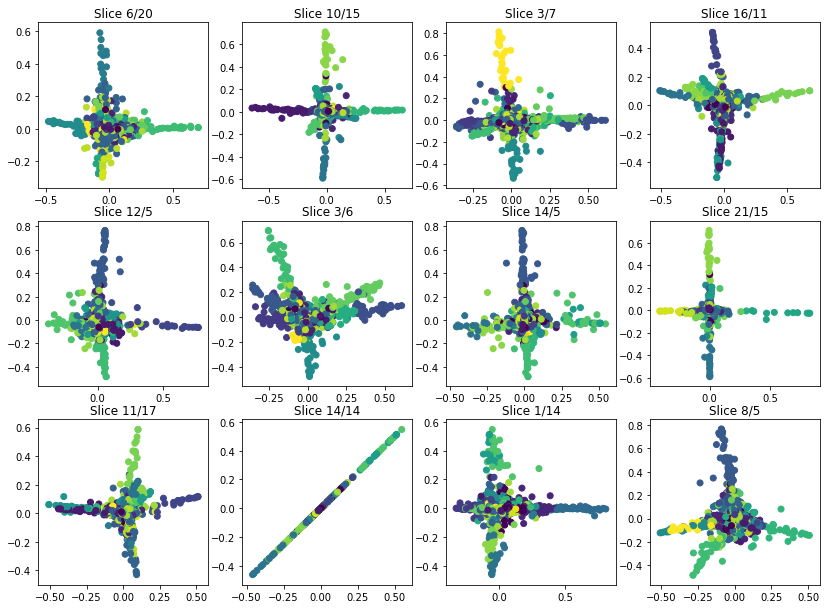

In [117]:

num_slices=22
plt.figure(figsize=(14, 14))
ar=np.random.randint(0,num_slices, size=12)
br=np.random.randint(0,num_slices, size=12)

for i in range(1,13):
    plt.subplot(4,4,int(i))
    plt.scatter(corpus_lda_dense[:, int(ar[i-1])], corpus_lda_dense[:, int(br[i-1])], c=pred)
    plt.title('Slice {}/{}'.format(str(ar[i-1]),str(br[i-1])))

plt.show()

In [118]:
def group_list(grp):
    g1=[]
    for i in range(0,pred.size):
        tid=subd.columns.levels[0][i]
        title=movd[movd.imdb_id == tid]['Title'].values[0]
        if pred[i] == grp:
            g1.append(title)
    print(g1,end=' ')

In [121]:
group_list(6)

['The Land Before Time', 'The Addams Family', 'Addams Family Values', 'Home Alone 3', 'Finding Nemo', 'Bend It Like Beckham', 'Garfield', 'Chicken Little', 'The Spiderwick Chronicles', 'Garfield: A Tail of Two Kitties', 'The Croods', 'The Princess and the Frog', 'Atonement', 'Interstellar', 'Unmistaken Child', 'The Impossible', 'Turbo', 'Finding Dory', 'Ice Age: Collision Course', 'The Shallows'] 

# Search for similar ones

In [122]:
def search_movie_else(search_name):
    id=False
    for item in movd['Title']:
        if search_name in item.lower():
            #print(movd[movd['Title']==item]['imdb_id'].values[0],item)
            id=movd[movd['Title']==item]['imdb_id'].values[0]
    return id  

def search_movie(query):
    id=False
    tit_id = dict(zip(list(movd['imdb_id'].values), list(movd['Title'].values.astype('str'))))
    print()
    print('Possible titles:')
    search_results=[]
    i=1
    for key,item in tit_id.items():
        
        if query in item.lower():
            search_results.append(key) 
            search_results.append(item)
            print(i,item)
            i = i+1
            
    #print(search_results)      
    
    if len(search_results)>2:
        num_t=input('Multiple found. Which one?')
        id=search_results[int(num_t)*2-2]
    else:
        id=search_results[0]
    return id

def find_closest_to(num):
    query=input('Which movie? ')
    movie_id=search_movie(query)
        
    if movie_id and movie_id in subd.columns.levels[0].values:
        movie=mtok_stem[movie_id]
        vec_movie=lda_mod[dictionary.doc2bow(movie)]
        index.num_best = num
        sims=index[vec_movie]
        
        print('------Similar titles to: {}------'.format(movd[movd.imdb_id == movie_id]['Title'].values[0]))
        i=1
        for item in sims:
            tid=subd.columns.levels[0][item[0]]
            title=movd[movd.imdb_id == tid]['Title'].values[0]
            print('                       {}.{}'.format(i, title))
            i = i+1        
    else:
        print('Chosing the last one... Ooops. Dont have it bro.')

def find_closest(num):
    imdb_id_random=subd.columns.levels[0][np.random.randint(0,len(subd.columns.levels[0])-1)]
    #query=mtok[imdb_id_random]
    #query=search_movie(input('Name a movie:'))
    #print(query)
    if imdb_id_random:
        movie=mtok_stem[imdb_id_random]
        vec_movie=lda_mod[dictionary.doc2bow(movie)]
        index.num_best = num
        sims=index[vec_movie]
        
        
        print('------Similar titles to: {}------'.format(movd[movd.imdb_id == imdb_id_random]['Title'].values[0]))
        i=1
        for item in sims:
            tid=subd.columns.levels[0][item[0]]
            title=movd[movd.imdb_id == tid]['Title'].values[0]
            print('             {}.{}'.format(i, title))
            i = i+1        

# Feature as a function of Time

In [123]:
def create_plot(y_ar,num_feature,movie_num):
    x=np.linspace(0,len(y_ar)-1,len(y_ar))
    y=y_ar[:,num_feature]
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    N = 200
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, N)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    #norm=mpl.colors.Normalize(vmin=0,vmax=50)
    #cmap=cm.jet
    #c_map=cmap(norm(num_feature))
    #color =c_map
    
    #plt.plot(x, y, 'bo', label='Original points')
    if movie_num ==1:
        plt.plot(xx, spline(xx),  label='Ft.#{} Mov.#{}'.format(num_feature,movie_num))
    if movie_num ==2:
        plt.plot(xx, spline(xx), '-.',  label='Ft.#{} Mov.#{}'.format(num_feature,movie_num))
    return
    
def movie_vectorize(movie):
    n=80 #number of word chunks at one time
    vec_movie=lda_mod[dictionary.doc2bow(movie)]
    chunk_movie=[movie[i:i + n] for i in range(0, len(movie), n)]
    chunk_movie_vec=[lda_mod[dictionary.doc2bow(text)] for text in chunk_movie]
    vec_array=matutils.corpus2dense(chunk_movie_vec,num_terms=lda_mod.num_topics).transpose()
    
    #for item in vec_movie:
    #   print(item)
    
    return vec_array
    
    
def pick_top_features(vec_array,num_feats):    
    
    feat_prevalence=[np.count_nonzero(vec_array[:,i]) for i in range(0,len(vec_array[1,:]))]   
    #counts which features shows up most
    
    top_features=sorted(range(len(feat_prevalence)), key=lambda i: -feat_prevalence[i])[:num_feats] 
    #picks index of most prominent features
    #pdb.set_trace()
    return top_features
    
def plot_features(num_feats):
    
    query=input('Which movie? ')
    movie_id=search_movie(query)
    title=movd[movd.imdb_id == movie_id]['Title'].values[0]
    print(title)
    
    vec_array=movie_vectorize(mtok_stem[movie_id])  #vectorizes movie
    top_features=pick_top_features(vec_array,num_feats)  #returns a list of the top features
    
    
    plt.figure(figsize=(16, 4))   
    plt.title('Time evolution of features in movie: {}'.format(title))
    plt.ylabel('Feature Strength')
    plt.xlabel('Time')
    plt.xticks([])
  
    for item in top_features:
        create_plot(vec_array,item,1)
       
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
    
def compare_features(num_feats):
    query1=input('Movie 1?')
    query2=input('Movie 2?')
    
    movie1_id=search_movie(query1)
    movie2_id=search_movie(query2)
    
    movie1=mtok_stem[movie1_id]
    movie2=mtok_stem[movie2_id]
    
    title1=movd[movd.imdb_id == movie1_id]['Title'].values[0]
    title2=movd[movd.imdb_id == movie2_id]['Title'].values[0]
    
    vec_array1=movie_vectorize(movie1)  #vectorizes movie
    vec_array2=movie_vectorize(movie2)  #vectorizes movie
    
    top_features1=pick_top_features(vec_array1,10)  #returns a list of the 10 top features
    top_features2=pick_top_features(vec_array2,10)  #returns a list of the 10 top features
    
    common_feats=list(set(top_features1).intersection(top_features2))
    
    
    
    if not common_feats: #if its empty - no common features
        print('No common features.')
    else: # if they do have common features
        print('{} and {} have {} common features.'.format(title1,title2,len(common_feats)))
        plt.figure(figsize=(16, 4))   
        plt.title('Common features time evolution in {}(1) & {}(2)'.format(title1,title2))
        plt.ylabel('Feature Strength')
        plt.xlabel('Time')
        plt.xticks([])

        for item in common_feats[0:num_feats]:
            create_plot(vec_array1,item,1)
            create_plot(vec_array2,item,2)

        plt.grid()
        plt.legend(loc='best')
        plt.show()
        

Which movie? avengers

Possible titles:
1 The Avengers
2 Avengers: Age of Ultron
Multiple found. Which one?1
The Avengers


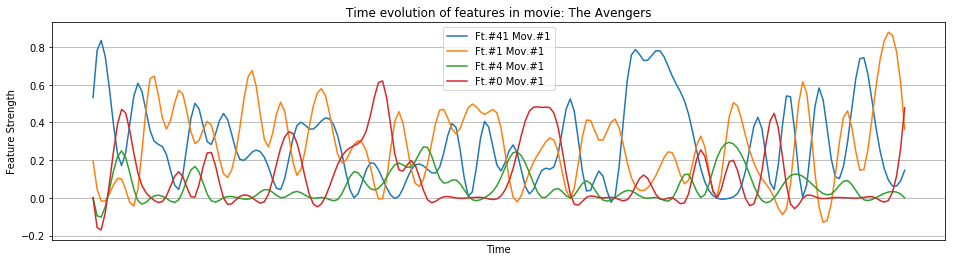

In [101]:
plot_features(4)

In [124]:
find_closest_to(20)

Which movie? matrix

Possible titles:
1 The Matrix Reloaded
2 The Matrix
3 The Matrix Revolutions
Multiple found. Which one?2
------Similar titles to: The Matrix------
                       1.The Matrix
                       2.Jacob's Ladder
                       3.The Pursuit of Happyness
                       4.Friday the 13th
                       5.Insidious
                       6.Sorority Row
                       7.House of Wax
                       8.The Skeleton Key
                       9.30 Days of Night
                       10.A Nightmare on Elm Street Part 2: Freddy's Revenge
                       11.The Haunted Mansion
                       12.A Nightmare on Elm Street
                       13.Halloween
                       14.Kill Bill: Vol. 1
                       15.Wolf Creek
                       16.Saturday Night Fever
                       17.Borat: Cultural Learnings of America for Make ..
                       18.Zootopia
                     

Movie 1?moana
Movie 2?avatar

Possible titles:
1 Moana

Possible titles:
1 Avatar
Moana and Avatar have 3 common features.


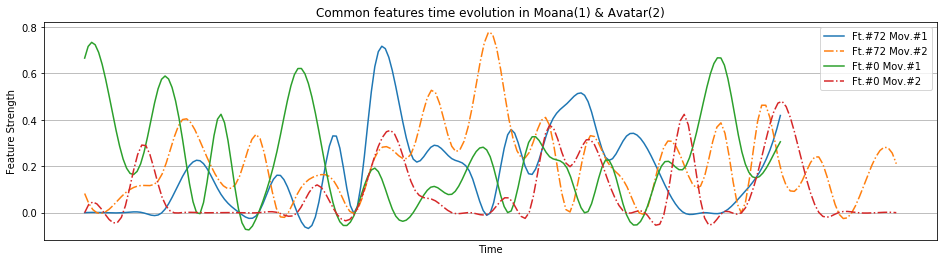

In [103]:
compare_features(2)

In [96]:
lda_mod.show_topic(40,topn=100)

[('scarlett', 0.027735978532443393),
 ('miss', 0.024175765178817123),
 ('ashley', 0.017955805106110393),
 ('melani', 0.015868045674541045),
 ('rhett', 0.011600673556195052),
 ('know', 0.011258396966887916),
 ('want', 0.009772243264200774),
 ('well', 0.0097404981931027666),
 ('think', 0.0093968279574530612),
 ('love', 0.009066168557103068),
 ('come', 0.0089569888577296693),
 ('ye', 0.0086360351779474175),
 ('like', 0.0084401797435634755),
 ('yanke', 0.008114525689111092),
 ('say', 0.0080427513183262411),
 ('go', 0.0079929541834059623),
 ('get', 0.0078491354461572398),
 ('good', 0.0078219141337974359),
 ('butler', 0.0068761070436907587),
 ('never', 0.0068366569510490477),
 ('got', 0.0065991495535669999),
 ('mr', 0.0060490195880644098),
 ('melli', 0.0059357199035872475),
 ('tell', 0.0057162325420205603),
 ('thing', 0.0056615166774475591),
 ('take', 0.0056299005361913164),
 ('wilk', 0.0054937572548549325),
 ('marri', 0.005169408460473905),
 ('war', 0.0047861031024788092),
 ('captain', 0.00